#챗봇 만들기

## 0. 경로 설정 및 라이브러리 임포트

In [10]:
# 필요한 라이브러리 임포트

import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [240]:
# 데이터 경로 지정
data_path = os.getenv('HOME')+"/aiffel/transformer_chatbot/data/ChatbotData.csv"  # 공백 포함
data = pd.read_csv(data_path)

## 1. 데이터 전처리
데이트 로드
질문(Q)과 답변(A) 데이터를 리스트로 추출:

In [241]:
# 데이터 확인
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [242]:
# 질문과 답변 추출
questions = data['Q'].tolist()
answers = data['A'].tolist()

### 문장 전처리:
불필요한 공백 제거 및 특수 문자 제거.

In [243]:
# 전처리 함수 수정
def preprocess_sentence(sentence):
    """
    문장을 정제하여 한국어, 영어, 숫자, 일부 특수문자만 남기고 나머지를 제거.
    """
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 한국어, 영어, 숫자, 구두점만 남기고 나머지 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    
    # 연속된 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence)
    
    return sentence

In [244]:
# 문장 전처리
questions = [preprocess_sentence(sentence) for sentence in questions]
answers = [preprocess_sentence(sentence) for sentence in answers]

시작 및 종료 토큰 추가:
챗봇 모델이 문장의 시작과 끝을 이해할 수 있도록 토큰 삽입.

In [245]:
# 시작 및 종료 토큰 추가
START_TOKEN = '<start>'
END_TOKEN = '<end>'

questions = [f"{START_TOKEN}{sentence}{END_TOKEN}" for sentence in questions]
answers = [f"{START_TOKEN}{sentence}{END_TOKEN}" for sentence in answers]



In [246]:
# corpus.txt 파일 생성
with open('corpus.txt', 'w', encoding='utf-8') as f:
    for sentence in questions + answers:
        f.write(sentence + '\n')
       
        
        
        


## 2. 토큰화 및 임베딩
목적: 텍스트를 숫자 벡터로 변환.


SentencePiece 모델 학습 및 로드

In [247]:
import sentencepiece as spm  # SentencePiece 사용

# SentencePiece 모델 학습을 위한 데이터 준비
with open('corpus.txt', 'w', encoding='utf-8') as f:
    for sentence in questions + answers:
        f.write(sentence + '\n')

In [248]:
# SentencePiece 모델 학습
# spm.SentencePieceTrainer.Train('--input=corpus.txt --model_prefix=spm --vocab_size=32000 --model_type=bpe')
#user symbol 지정 해주어야 인식함(--user_defined_symbols=<start>,<end>로 등록.)

spm.SentencePieceTrainer.Train('--input=corpus.txt --model_prefix=spm --vocab_size=32000 --model_type=bpe --user_defined_symbols=<start>,<end>')

In [249]:
#반복방지 로직 추가

def decode_with_penalty(model, input_sequence, penalty_factor=1.2):
    logits = model(input_sequence, training=False)
    
    # 반복 방지 로직 추가
    for step in range(MAX_LENGTH):
        token_id = tf.argmax(logits[step]).numpy()
        if token_id in generated_ids:
            logits[step] /= penalty_factor  # 반복된 토큰의 확률 감소

        generated_ids.append(token_id)
    return generated_ids

In [250]:
# SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('spm.model')

True

In [251]:
# 시작 및 종료 토큰의 ID 확인
START_TOKEN_ID = sp.piece_to_id('<start>')  # 사용자 정의 심볼
END_TOKEN_ID = sp.piece_to_id('<end>')      # 사용자 정의 심볼

# 결과 출력
print('START_TOKEN_ID:', START_TOKEN_ID)
print('END_TOKEN_ID:', END_TOKEN_ID)

START_TOKEN_ID: 3
END_TOKEN_ID: 4


In [252]:
#학습된 심볼 목록 출력

for i in range(10):  # 상위 10개 토큰만 출력
    print(f"ID {i}: {sp.id_to_piece(i)}")

ID 0: <unk>
ID 1: <s>
ID 2: </s>
ID 3: <start>
ID 4: <end>
ID 5: 세요
ID 6: ▁사
ID 7: ▁있
ID 8: ▁좋
ID 9: ▁거


In [253]:
# 토큰화 함수 정의
def encode_sentence(sentence):
    return sp.EncodeAsIds(sentence)

토큰화:
SentencePiece로 각 문장을 토큰 ID로 변환.

In [254]:
# 토큰화 적용
question_sequences = [encode_sentence(sentence) for sentence in questions]
answer_sequences = [encode_sentence(sentence) for sentence in answers]


패딩 처리:
시퀀스 길이를 MAX_LENGTH에 맞춰 일치시킴

In [255]:
# 최대 시퀀스 길이 설정
MAX_LENGTH = 40  # 필요에 따라 조정

# 패딩을 통해 시퀀스 길이 일치
question_sequences = tf.keras.preprocessing.sequence.pad_sequences(question_sequences, maxlen=MAX_LENGTH, padding='post')
answer_sequences = tf.keras.preprocessing.sequence.pad_sequences(answer_sequences, maxlen=MAX_LENGTH, padding='post')


### 디코더 입력 및 출력 생성:
디코더 입력: answer_sequences에서 마지막 토큰 제외.
디코더 출력: answer_sequences에서 첫 번째 토큰 제외.

In [256]:
#디코더 입력과 출력 생성
decoder_inputs = answer_sequences[:, :-1]
decoder_outputs = answer_sequences[:, 1:]

# 디코더 입력과 출력의 시퀀스 길이를 MAX_LENGTH로 패딩
decoder_inputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_inputs, maxlen=MAX_LENGTH, padding='post')
decoder_outputs = tf.keras.preprocessing.sequence.pad_sequences(decoder_outputs, maxlen=MAX_LENGTH, padding='post')

### 데이터셋 준비
모델 학습에 사용할 데이터셋 구성.

In [257]:
# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': question_sequences,
        'dec_inputs': decoder_inputs
    },
    decoder_outputs
))



In [258]:
# 배치 크기 설정
BATCH_SIZE = 64

# 데이터셋 셔플 및 배치 처리
BUFFER_SIZE = len(question_sequences)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 단어 집합의 크기
VOCAB_SIZE = sp.GetPieceSize()

print('단어 집합의 크기:', VOCAB_SIZE)

단어 집합의 크기: 32000


In [299]:
# 학습 및 검증 데이터셋 분리 (80% 학습, 20% 검증)
train_qs, val_qs, train_dec_inputs, val_dec_inputs, train_dec_outputs, val_dec_outputs = train_test_split(
    question_sequences, decoder_inputs, decoder_outputs, test_size=0.2, random_state=42
)

# 학습 데이터셋 구성
BUFFER_SIZE = len(train_qs)
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_qs,             # 인코더 입력
        'dec_inputs': train_dec_inputs  # 디코더 입력
    },
    train_dec_outputs                   # 디코더 출력
)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 검증 데이터셋 구성
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_qs,             # 인코더 입력
        'dec_inputs': val_dec_inputs  # 디코더 입력
    },
    val_dec_outputs                   # 디코더 출력
)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


## 3. 임베딩 함수 및  Transformer 구성

### 구성요소 정의:
포지셔널 인코딩: positional_encoding()
패딩 마스크 생성 
룩어헤드 마스크 생성
피드 포워드 네트워크: point_wise_feed_forward_network().
멀티헤드 어텐션: MultiHeadAttention 클래스.

In [300]:
# 포지셔널 인코딩 생성 함수
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 짝수 인덱스
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 홀수 인덱스
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [260]:
# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [261]:

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(seq_len):
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # (seq_len, seq_len)
    return mask

In [301]:
# 멀티헤드 어텐션 레이어
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)  # Query
        self.wk = tf.keras.layers.Dense(d_model)  # Key
        self.wv = tf.keras.layers.Dense(d_model)  # Value

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # x.shape == (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # x.shape == (batch_size, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])
        # x.shape == (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  # 매우 작은 값 추가

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        output = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len_q, depth)

        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output

In [263]:
# 포인트 와이즈 피드 포워드 네트워크
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

### 인코더와 디코더 구현:
인코더: EncoderLayer와 Encoder 클래스.
디코더: DecoderLayer와 Decoder 클래스.

In [302]:
# 인코더 레이어
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        # 멀티헤드 어텐션
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # 잔차 연결과 레이어 노멀라이제이션



        # 피드 포워드 네트워크
        ffn_output = self.ffn(out1)  # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # 잔차 연결과 레이어 노멀라이제이션



        return out2

    
 # 인코더
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 vocab_size, maximum_position_encoding, dropout_rate):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 임베딩 및 포지셔널 인코딩
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 스케일링
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)



        # 인코더 레이어 통과
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, seq_len, d_model)
   

In [265]:
# 디코더 레이어
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)  # 마스크드 멀티헤드 어텐션
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # 인코더-디코더 어텐션

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # 마스크드 멀티헤드 어텐션 (셀프 어텐션)
        attn1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)



        # 인코더-디코더 어텐션
        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)



        # 피드 포워드 네트워크
        ffn_output = self.ffn(out2)  # (batch_size, seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

 
        return out3

# 디코더
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 vocab_size, maximum_position_encoding, dropout_rate):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]

        # 임베딩 및 포지셔널 인코딩
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 스케일링
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)



        # 디코더 레이어 통과
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training,
                                   look_ahead_mask, padding_mask)

        return x  # (batch_size, seq_len, d_model)


## 4. Transformer 모델 정의

전체 트랜스포머 모델 정의:

In [303]:
# 트랜스포머 모델
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 vocab_size, maximum_position_encoding, dropout_rate):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               vocab_size, maximum_position_encoding, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               vocab_size, maximum_position_encoding, dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, training):
        enc_inputs = inputs['inputs']
        dec_inputs = inputs['dec_inputs']

        enc_padding_mask = create_padding_mask(enc_inputs)
        dec_padding_mask = create_padding_mask(enc_inputs)

        look_ahead_mask = create_look_ahead_mask(tf.shape(dec_inputs)[1])
        dec_target_padding_mask = create_padding_mask(dec_inputs)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        enc_output = self.encoder(enc_inputs, training, enc_padding_mask)

        dec_output = self.decoder(dec_inputs, enc_output, training,
                                  combined_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

    
        return final_output



In [304]:
# 하이퍼파라미터 설정
NUM_LAYERS = 6 #논문 기본값 사용
D_MODEL = 512 #논문 기본값 사용
NUM_HEADS = 8 #논문 기본값 사용
DFF = 2048 #논문 기본값 사용
DROPOUT_RATE = 0.1 #논문 기본값 사용

MAX_POSITION_ENCODING = MAX_LENGTH #논문에서 512사용 되었으나, 문장의 최대길이로 변경

# 모델 생성
model = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    vocab_size=VOCAB_SIZE,
    maximum_position_encoding=MAX_POSITION_ENCODING,
    dropout_rate=DROPOUT_RATE)



## 5. 학습 및 최적화

손실 함수 및 학습률 스케줄링:
손실 함수: loss_function().
학습률 스케줄링: CustomSchedule 클래스.

In [268]:
# # 손실 함수 정의(기존)
# def loss_function(y_true, y_pred):
#     y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH))
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(
#         from_logits=True, reduction='none')(y_true, y_pred)

#     mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#     loss = tf.multiply(loss, mask)

#     return tf.reduce_mean(loss)



In [305]:
# 손실 함수 정의(개선)

# 손실 함수 정의
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

손실함수 개선 진행함

| **항목**                 | **기본 손실 함수**                               | **수정된 손실 함수**                           |
|--------------------------|------------------------------------------------|-----------------------------------------------|
| **패딩 토큰 처리**        | 패딩 포함 손실 계산                              | 패딩 토큰의 손실을 무시                        |
| **손실 값 계산 방식**     | 전체 토큰 평균 손실                              | 마스크 적용 후 패딩 제외 손실 평균             |
| **`reduction` 옵션**      | `auto` (자동 평균화)                            | `none` (개별 손실 계산 후 평균화)              |
| **장점**                 | 간단한 구현                                     | 패딩 무시로 학습 안정성 향상                   |


In [306]:

# 학습률 스케줄러 정의
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [271]:
# 옵티마이저 설정
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [ ]:
# # 정확도 계산 함수(개선,  패딩 토큰 무시)

# def accuracy(y_true, y_pred):
#     y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH))
#     y_pred = tf.argmax(y_pred, axis=-1)  # 예측값의 가장 높은 확률 토큰 선택

#     # 패딩 토큰 무시
#     mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#     correct_predictions = tf.cast(tf.equal(y_true, y_pred), tf.float32) * mask

#     return tf.reduce_sum(correct_predictions) / tf.reduce_sum(mask)  # 패딩 제외 정확도 계산

In [278]:
# 문장 단위 정확도
# 모든 토큰이 정답과 일치하는 문장만 정답으로 간주하는 방식으로 정확도를 계산할 수도 있습니다.


def sentence_accuracy(y_true, y_pred):
    """
    문장 단위 정확도 계산 함수.
    y_true: 실제 정답 (int64)
    y_pred: 모델 출력 (float32 logits)
    """
    y_true = tf.cast(y_true, tf.int64)  # y_true를 int64로 변환
    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int64)  # y_pred에서 argmax로 가장 높은 확률 토큰 선택

    # 문장 단위 정확도 계산 (모든 토큰이 동일한 문장만 True로 간주)
    correct_sentences = tf.reduce_all(tf.equal(y_true, y_pred), axis=1)
    return tf.reduce_mean(tf.cast(correct_sentences, tf.float32))  # 평균 정확도 반환


In [279]:
# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[sentence_accuracy])

In [233]:
# # 체크포인트 경로 설정
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)

# # 체크포인트 매니저 설정
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # # 특정 체크포인트 복원
# # checkpoint_path = "./checkpoints/train/ckpt-100"  # 복원할 체크포인트 경로

# # # 체크포인트 로드
# # ckpt.restore(checkpoint_path).expect_partial()  # 일부 변수만 복원될 경우 사용

# # # 복원 완료 메시지 출력
# # print(f'Checkpoint restored from {checkpoint_path}!')


# # 이전 체크포인트가 있으면 복원
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('최신 체크포인트 복원 완료!')

# # 에포크 반복 학습
# EPOCHS = 1 # 필요에 따라 조정
# for epoch in range(EPOCHS):
#     print(f'Epoch {epoch+1}/{EPOCHS}')
#     model.fit(dataset, epochs=1)
    
#     # 에포크마다 체크포인트 저장
#     ckpt_save_path = ckpt_manager.save()
#     print(f'에포크 {epoch+1} 체크포인트 저장: {ckpt_save_path}')

최신 체크포인트 복원 완료!
Epoch 1/1
185/185 [==============================] - 91s 384ms/step - loss: 0.9959 - accuracy: 0.0621
에포크 1 체크포인트 저장: ./checkpoints/train/ckpt-146


In [297]:



# 체크포인트 경로와 매니저 설정
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 체크포인트 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('이전 체크포인트 복원이 완료되었습니다!')

# 에포크 수 설정
EPOCHS = 10  # 학습 반복 수
history_data = {'loss': [], 'val_loss': [], 'sentence_accuracy': [], 'val_sentence_accuracy': []}

# 학습 및 히스토리 저장
for epoch in range(EPOCHS):
    print(f"에포크 {epoch + 1}/{EPOCHS} 시작")
    
    # 모델 학습
    history = model.fit(
        dataset, 
        validation_data=val_dataset,
        epochs=30  # 한 번의 에포크마다 체크포인트 저장
    )
    
    # 히스토리 저장
    history_data['loss'].append(history.history['loss'][0])
    history_data['sentence_accuracy'].append(history.history['sentence_accuracy'][0])
    

    # 체크포인트 저장
    ckpt_save_path = ckpt_manager.save()
    print(f"체크포인트 저장 완료: {ckpt_save_path}")



이전 체크포인트 복원이 완료되었습니다!
에포크 1/10 시작
Epoch 1/30
185/185 [==============================] - 71s 385ms/step - loss: 0.3721 - sentence_accuracy: 0.0000e+00
Epoch 2/30
185/185 [==============================] - 73s 394ms/step - loss: 0.3540 - sentence_accuracy: 0.0000e+00
Epoch 3/30
185/185 [==============================] - 73s 394ms/step - loss: 0.3381 - sentence_accuracy: 0.0000e+00
Epoch 4/30
185/185 [==============================] - 73s 394ms/step - loss: 0.3246 - sentence_accuracy: 0.0000e+00
Epoch 5/30
185/185 [==============================] - 73s 394ms/step - loss: 0.3092 - sentence_accuracy: 0.0000e+00
Epoch 6/30
124/185 [===================>..........] - ETA: 24s - loss: 0.2889 - sentence_accuracy: 0.0000e+00

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

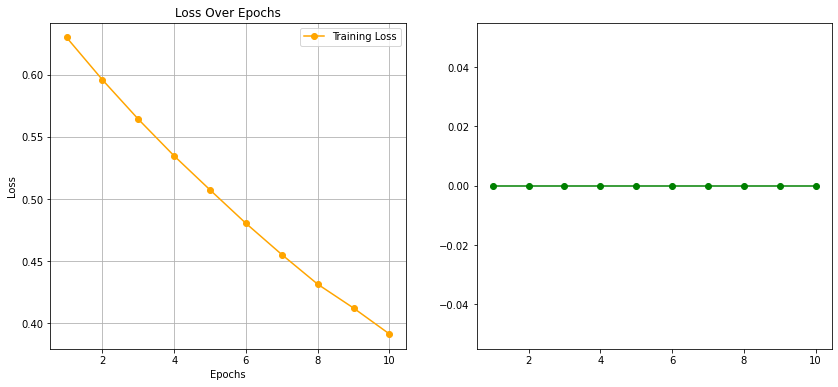

In [282]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt


epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['loss'], marker='o', label='Training Loss', color='orange')

plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_data['sentence_accuracy'], marker='o', label='Training Accuracy', color='green')
plt.plot(epochs, history_data['val_sentence_accuracy'], marker='o', label='Validation Accuracy', color='purple')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [234]:
# 체크포인트 경로 설정
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)

# 체크포인트 매니저 설정
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # 특정 체크포인트 복원
# checkpoint_path = "./checkpoints/train/ckpt-100"  # 복원할 체크포인트 경로

# # 체크포인트 로드
# ckpt.restore(checkpoint_path).expect_partial()  # 일부 변수만 복원될 경우 사용

# # 복원 완료 메시지 출력
# print(f'Checkpoint restored from {checkpoint_path}!')


# 이전 체크포인트가 있으면 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('최신 체크포인트 복원 완료!')

# 에포크 반복 학습
EPOCHS = 1 # 필요에 따라 조정
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    model.fit(dataset, epochs=1)
    
    # 에포크마다 체크포인트 저장
    ckpt_save_path = ckpt_manager.save()
    print(f'에포크 {epoch+1} 체크포인트 저장: {ckpt_save_path}')

최신 체크포인트 복원 완료!
Epoch 1/4
185/185 [==============================] - 73s 395ms/step - loss: 0.8014 - accuracy: 0.0741
에포크 1 체크포인트 저장: ./checkpoints/train/ckpt-147
Epoch 2/4
185/185 [==============================] - 73s 395ms/step - loss: 0.7488 - accuracy: 0.0752
에포크 2 체크포인트 저장: ./checkpoints/train/ckpt-148
Epoch 3/4
185/185 [==============================] - 73s 395ms/step - loss: 0.7042 - accuracy: 0.0764
에포크 3 체크포인트 저장: ./checkpoints/train/ckpt-149
Epoch 4/4
185/185 [==============================] - 73s 395ms/step - loss: 0.6659 - accuracy: 0.0777
에포크 4 체크포인트 저장: ./checkpoints/train/ckpt-150


In [235]:
print(model.summary())

Model: "transformer_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  35298304  
_________________________________________________________________
decoder_4 (Decoder)          multiple                  41608192  
_________________________________________________________________
dense_484 (Dense)            multiple                  16416000  
Total params: 93,322,496
Trainable params: 93,322,496
Non-trainable params: 0
_________________________________________________________________
None


모델 컴파일 및 학습

## 6. 챗봇 응답 생성
학습된 모델로 사용자 질문에 대한 응답 생성.


### 인코더 출력 생성:

입력 문장을 토큰화한 후 인코더에 전달.

In [283]:
# 예측 함수 정의
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = START_TOKEN + ' ' + sentence + ' ' + END_TOKEN

    input_sequence = sp.EncodeAsIds(sentence)
    input_sequence = tf.keras.preprocessing.sequence.pad_sequences([input_sequence], maxlen=MAX_LENGTH, padding='post')

    #디코딩 결과에서 <start>와 <end>를 제거하는 로직을 추가
    output_sentence = sp.DecodeIds(predicted_ids)
    output_sentence = output_sentence.replace("<start>", "").replace("<end>", "").strip()

    for i in range(MAX_LENGTH):
        inputs = {
            'inputs': input_sequence,
            'dec_inputs': output_sequence
        }

        predictions = model(inputs, training=False)
        predictions = predictions[:, -1:, :]  # 마지막 토큰에 대한 예측
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0][0]

        if predicted_id == END_TOKEN_ID:
            break

        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)

    predicted_sentence = sp.DecodeIds(output_sequence.numpy()[0].tolist())
    # 시작 및 종료 토큰을 정확히 제거
    predicted_sentence = predicted_sentence.replace('<s>', '').replace('</s>', '').strip()

    return predicted_sentence



In [293]:
def evaluate(sentence):
    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    sentence = START_TOKEN + sentence + END_TOKEN

    # 입력 문장 인코딩 및 패딩
    input_sequence = sp.EncodeAsIds(sentence)
    input_sequence = tf.keras.preprocessing.sequence.pad_sequences(
        [input_sequence], maxlen=MAX_LENGTH, padding='post'
    )

    # 디코딩 시작
    output_sequence = tf.constant([[START_TOKEN_ID]], dtype=tf.int64)  # 디코더 입력 초기화
    predicted_ids = []  # 생성된 토큰 ID를 저장할 리스트

    for i in range(MAX_LENGTH):
        inputs = {  # 모델 입력에 맞게 조정
            'inputs': input_sequence,
            'dec_inputs': output_sequence
        }

        # 모델 예측
        predictions = model(inputs, training=False)
        predictions = predictions[:, -1:, :]  # 마지막 토큰에 대한 예측
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0][0]

        # 종료 토큰 생성 시 디코딩 종료
        if predicted_id == END_TOKEN_ID:
            break

        # 생성된 ID를 리스트와 디코더 입력에 추가
        predicted_ids.append(predicted_id)
        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)

    # 리스트를 정수로 변환
    predicted_ids = [int(id) for id in predicted_ids]

    # 생성된 토큰 ID 디코딩
    predicted_sentence = sp.DecodeIds(predicted_ids)

    # 시작 및 종료 토큰 제거
    predicted_sentence = predicted_sentence.replace(START_TOKEN, "").replace(END_TOKEN, "").strip()

    return predicted_sentence


### 디코더 단계별 예측:

디코더가 한 단어씩 예측하여 응답 생성.

In [294]:
def predict(sentence):
    prediction = evaluate(sentence)
    print('질문:', sentence)
    print('답변:', prediction)
    return prediction

### 출력:

디코딩된 응답을 사용자에게 반환.

In [295]:
# 예시 질문에 대한 답변 생성
sample_questions = [
    "안녕하세요?",
    "오늘 날씨 어때?",
    "취업 준비 어떻게 해야 하나요?",
    "머리가 아파요",
    "당신은 누구인가요?"
]

for question in sample_questions:
    predict(question)
    print('-------------------------')

질문: 안녕하세요?
답변: 한번 해보세요.
-------------------------
질문: 오늘 날씨 어때?
답변: 혼자 사는 것보다 불편하겠죠.
-------------------------
질문: 취업 준비 어떻게 해야 하나요?
답변: 충분히 잘하고 아프겠네요.
-------------------------
질문: 머리가 아파요
답변: 누구든 디자이너에게 여쭤보세요.
-------------------------
질문: 당신은 누구인가요?
답변: 힘들겠네요.
-------------------------


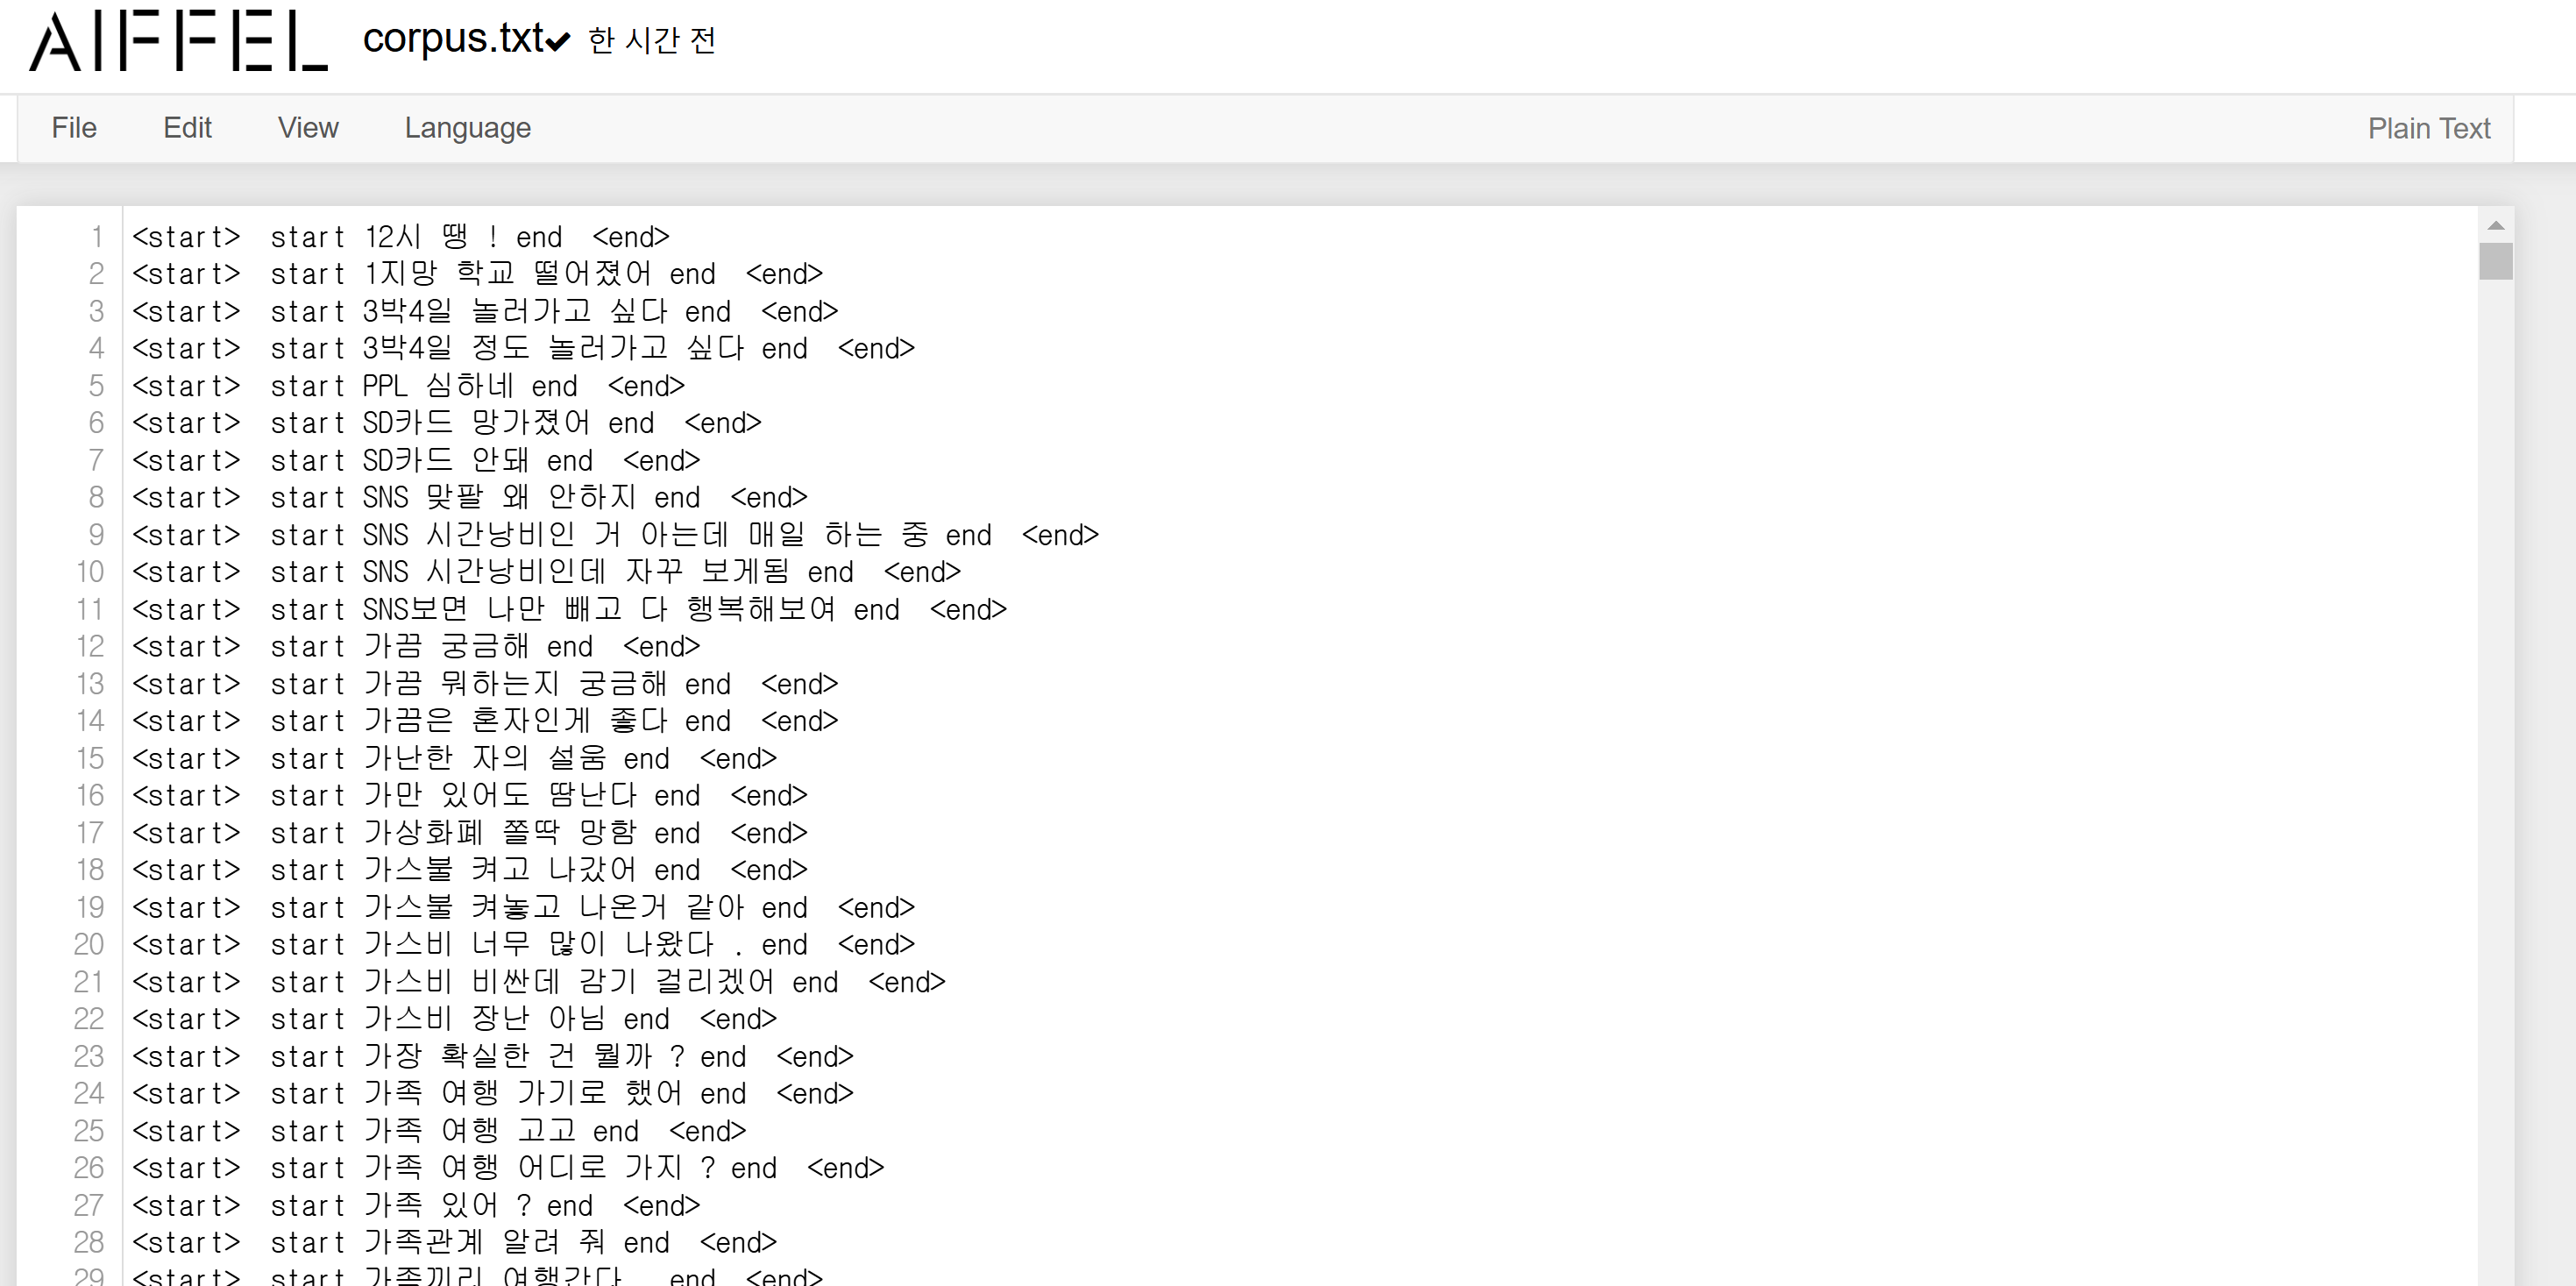
corpus의 잘못 된 데이터

## 회고

1. corpus의 잘못 된 데이터로 인하여 결과 값이 제대로 출력 되지 않았다(시작과 종결 토큰이 두번 들어가거나, 띄어쓰기)
   이 부분은 전처리 과정에서 공백을 제거하고, 커스텀 토큰을 지정했다.
또 loss에서 관련 토큰의 가중치를 조정하여 출력하지 않도로 개선하였다.

2. LMS 상의 축소 된 모델에서 논문에 사용 된 원래의 모델을 사용하였으나, 성능이 개선되지 않았다.
복잡한 모델이라고 좋은 것이 아니며, 데이터셋의 숫자가 작을 때에는 단순한 모델이 효과적일 수 있다.

3. checkpoint를 이용하여 지난번 학습된 모델을 불러와 사용하는 것은 매우 효과적이다.